In [381]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
import torch.utils.data as data
import zuko

from pathlib import Path
import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code"))

from Basic_functions import Cartesian, kernel, get_Sqs

In [313]:

def f_given_parameters(thetas, parameters, modes = 1, sample_size = 1000):
    """
    thetas: which is a matrix of size (n, 2)
    parameters: which is a vector of size (6 * modes,)
    """
    if len(parameters) != modes * 6:
        raise ValueError("Parameters should be of length modes * 6")
    
    mu_x = parameters[:modes]
    mu_y = parameters[modes:2*modes]
    sigma_x = parameters[2*modes:3*modes]
    sigma_y = parameters[3*modes:4*modes]
    rho = parameters[4*modes:5*modes]
    weights = parameters[5*modes:]

    weights = np.asarray(weights)
    weights = weights / weights.sum()

    f_thetas = np.zeros(thetas.shape[0])
    means = []
    covs = []

    for i in range(modes):
        mean = [mu_x[i], mu_y[i]]
        cov = [ 
            [sigma_x[i]**2, rho[i]*sigma_x[i]*sigma_y[i]],
            [rho[i]*sigma_x[i]*sigma_y[i], sigma_y[i]**2]
        ]
        means.append(mean)
        covs.append(cov)

        MultiNormal = multivariate_normal(mean=mean, cov=cov)
        f_thetas += weights[i] * MultiNormal.pdf(thetas)

    components = np.random.choice(modes, size=sample_size, p=weights)
    samples = np.array([
        np.random.multivariate_normal(mean=means[c], cov=covs[c])
        for c in components
    ])
    
    return f_thetas, samples

def synthetic_f(theta1, theta2, modes = 1, sample_size = 1000):

    thetas, _ = Cartesian(theta1, theta2)
    

    mu_x = np.empty(modes)
    mu_y = np.empty(modes)
    sigma_x = np.empty(modes)
    sigma_y = np.empty(modes)
    rho = np.empty(modes)
    weights = np.random.dirichlet([1]* modes)

    for i in range(modes):
        while True:
            mu_x[i] = np.random.uniform(np.min(theta1), np.max(theta1))
            mu_y[i] = np.random.uniform(np.min(theta2), np.max(theta2))
            sigma_x[i] = np.random.uniform(0.05, np.max(theta1)/6)
            sigma_y[i] = np.random.uniform(1, np.max(theta2)/6)
            rho[i] = np.random.uniform(-0.9, 0.9)

            if (mu_x[i] + 3*sigma_x[i] < np.max(theta1) and 
                mu_x[i] - 3*sigma_x[i] > np.min(theta1) and 
                mu_y[i] + 3*sigma_y[i] < np.max(theta2) and 
                mu_y[i] - 3*sigma_y[i] > np.min(theta2)):
                break

    idx = np.argsort(mu_x) # sort by mu_x!!!!
    mu_x = mu_x[idx]
    mu_y = mu_y[idx]
    sigma_x = sigma_x[idx]
    sigma_y = sigma_y[idx]
    rho = rho[idx]
    weights = weights[idx]

    parameters = np.concatenate([mu_x, mu_y, sigma_x, sigma_y, rho, weights])

    f_thetas, samples = f_given_parameters(thetas, parameters, modes, sample_size)
    
    return f_thetas, parameters, samples

def synthetic_Sqs(q1, q2, theta1, theta2, f_thetas, sigma = 0):
    ## This function generates a synthetic Sqs given the designed qs
    qs, _ = Cartesian(q1, q2)
    thetas, weights = Cartesian(theta1, theta2)
    ker_mat = kernel(qs, thetas)
    Sqs = get_Sqs(ker_mat, weights, f_thetas, sigma = sigma)
    return qs, Sqs


### Plot

In [314]:
def compare_contour(theta1, theta2, samples, f_true):
    ## This is a plotting function to visualize the results of the recovered density function and the recoveredS(q)
    """
    theta1: which is a vector of size (n1,)
    theta2: which is a vector of size (n2,)
    """
    theta11, theta22 = np.meshgrid(theta1, theta2)
    f_true_reshape = f_true.reshape(theta11.shape, order='F')

    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    contourplot = axs[0].contourf(theta11, theta22, f_true_reshape, levels=50, cmap='hot')
    axs[0].set_xlabel(r'D (${\mu m}^2/ms$)')
    axs[0].set_ylabel(r'R ($s^{-1}$)')
    axs[0].set_title('True')
    plt.colorbar(contourplot, ax=axs[0])

    xy = np.vstack([samples[:,0], samples[:,1]])
    kde = gaussian_kde(xy)
    Z = kde(np.vstack([theta11.ravel(), theta22.ravel()])).reshape(theta11.shape)

    true_contour = axs[1].contourf(theta11, theta22, Z, levels=50, cmap='hot')
    axs[1].set_xlabel(r'D (${\mu m}^2/ms$)')
    axs[1].set_ylabel(r'R ($s^{-1}$)')
    axs[1].set_title('Recovered')
    plt.colorbar(true_contour, ax=axs[1])

    plt.show()

    return Z

### Training Data

In [330]:
q1 = np.linspace(0.7, 3.5, 5)
q2 = np.linspace(0.071, 0.191, 5)
qs, _ = Cartesian(q1, q2)

theta1 = np.linspace(0, 2, 50)
theta2 = np.linspace(0, 100, 50)
thetas, weights = Cartesian(theta1, theta2)

number = 2048
sample_size = 512

Sqs = np.zeros((number, qs.shape[0]))
f_thetas = np.zeros((number, thetas.shape[0]))
samples = np.zeros((number, sample_size, 2))

for i in range(number):
    f_thetas[i,:], _, samples[i,:,:] = synthetic_f(theta1, theta2, modes = 1, sample_size=sample_size) # np.random.randint(1, 2)
    _, Sqs[i, :] = synthetic_Sqs(q1, q2, theta1, theta2, f_thetas[i,:], sigma = 0.0003)

Sqs_torch = torch.tensor(np.repeat(Sqs, sample_size, axis=0), dtype=torch.float32)
samples_torch = torch.tensor(np.squeeze(samples.reshape(1, -1, 2), axis = 0), dtype=torch.float32)

trainset = data.TensorDataset(samples_torch, Sqs_torch)
trainloader = data.DataLoader(trainset, batch_size = 128, shuffle=True)


### Model

In [331]:
flow = zuko.flows.MAF(features = 2, context = len(q1) * len(q2), transforms=4, hidden_features=[64, 64])
optimizer = Adam(flow.parameters(), lr=1e-2)
average_losses = []


for epoch in range(50):

    losses = []

    for samples_torch, Sqs_batch in trainloader:

        dist = flow(Sqs_batch)

        loss = -dist.log_prob(samples_torch).mean()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())

    average_losses.append(np.array(losses).mean())

    if (epoch+1) % 1 == 0:
        # -flow(Sqs_test).log_prob(samples_test)).mean()
        print(f"Finished: {epoch+1}, NLL Loss: {np.array(losses).mean():.6f}")


Finished: 1, NLL Loss: 3.471978
Finished: 2, NLL Loss: 3.005684
Finished: 3, NLL Loss: 2.973136
Finished: 4, NLL Loss: 2.955493
Finished: 5, NLL Loss: 2.941371
Finished: 6, NLL Loss: 2.928200
Finished: 7, NLL Loss: 2.921851
Finished: 8, NLL Loss: 2.914039
Finished: 9, NLL Loss: 2.911314
Finished: 10, NLL Loss: 2.905876
Finished: 11, NLL Loss: 2.901745
Finished: 12, NLL Loss: 2.897350
Finished: 13, NLL Loss: 2.892896
Finished: 14, NLL Loss: 2.890900
Finished: 15, NLL Loss: 2.886611
Finished: 16, NLL Loss: 2.883475
Finished: 17, NLL Loss: 2.881664
Finished: 18, NLL Loss: 2.880213
Finished: 19, NLL Loss: 2.877288
Finished: 20, NLL Loss: 2.875507
Finished: 21, NLL Loss: 2.871366
Finished: 22, NLL Loss: 2.870107
Finished: 23, NLL Loss: 2.869101
Finished: 24, NLL Loss: 2.866262
Finished: 25, NLL Loss: 2.873799
Finished: 26, NLL Loss: 2.870568
Finished: 27, NLL Loss: 2.868168
Finished: 28, NLL Loss: 2.866430
Finished: 29, NLL Loss: 2.865309
Finished: 30, NLL Loss: 2.863123
Finished: 31, NLL L

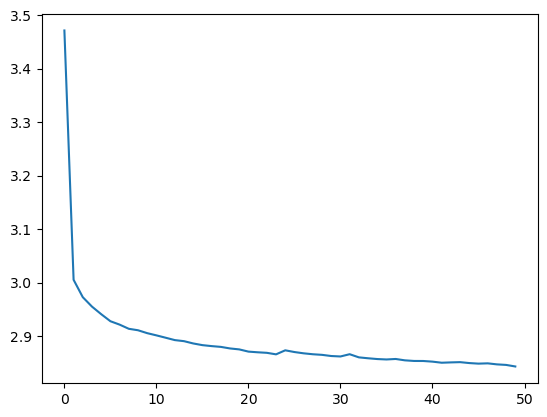

In [332]:
plt.plot(average_losses)

### Test

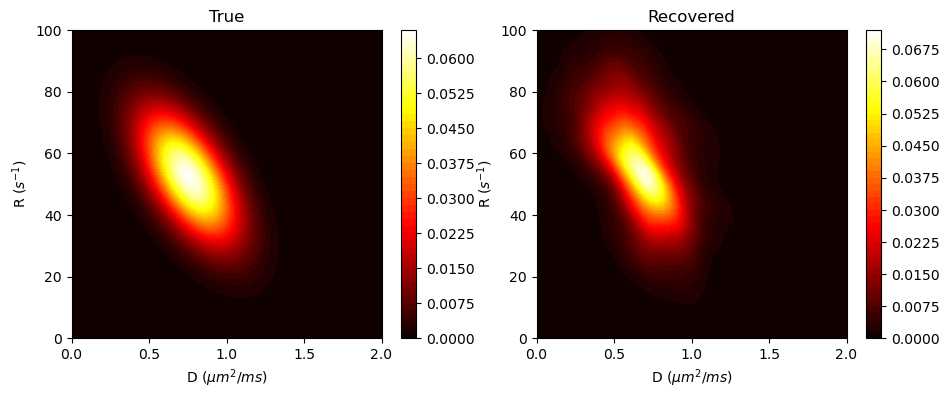

array([[5.21545317e-038, 4.29948347e-033, 1.13762026e-028, ...,
        1.71843678e-024, 1.94166887e-025, 7.51468034e-027],
       [3.59554832e-035, 2.08212651e-030, 3.86981022e-026, ...,
        1.69672322e-022, 1.42507386e-023, 3.87811370e-025],
       [1.61324333e-032, 6.56236518e-028, 8.56737452e-024, ...,
        1.14513938e-020, 6.81281820e-022, 1.30256283e-023],
       ...,
       [4.61705331e-004, 4.28819865e-004, 4.49854176e-004, ...,
        9.30137075e-096, 3.64474917e-105, 4.58289558e-115],
       [3.68882891e-004, 3.24219630e-004, 4.03670904e-004, ...,
        5.33131130e-100, 1.46749723e-109, 1.29620040e-119],
       [2.61234942e-004, 2.61657404e-004, 3.99880246e-004, ...,
        1.98877437e-104, 3.84548825e-114, 2.38599247e-124]])

In [378]:
f_thetas_test, _, _ = synthetic_f(theta1, theta2, modes=np.random.choice([1]))
_, Sqs_test = synthetic_Sqs(q1, q2, theta1, theta2, f_thetas_test, sigma=0.001)


# Prepare test input
Sqs_test_torch = torch.tensor(Sqs_test, dtype=torch.float32).unsqueeze(0) 

# Sample predicted results from the trained flow
flow.eval()
with torch.no_grad():
    dist = flow(Sqs_test_torch)                   
    samples = dist.rsample((10000,)).squeeze().numpy()

# Compare the true and predicted density functions
compare_contour(theta1, theta2, samples, f_thetas_test)


In [334]:
torch.save(flow, '/Users/xunan/Projects/MaxEnt/Zuko_2D_samples.pt')


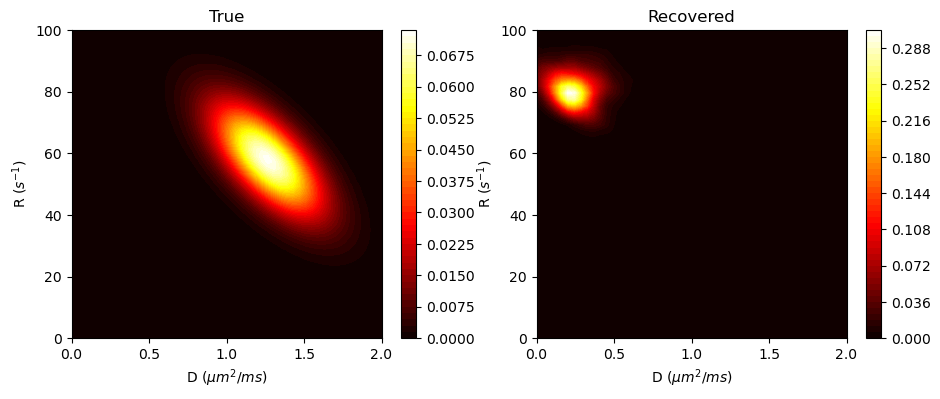

In [357]:
Sqs_noisy = np.array([ 3.18478486e-03,  3.86019005e-04, -1.75937685e-05,
         4.63857708e-04,  4.41230673e-04,  2.96518800e-03,
         4.11844734e-04, -2.35601764e-04, -5.91049822e-04,
        -1.04040255e-04,  2.41184742e-03,  6.09516615e-04,
         3.85338751e-04, -1.13657186e-04, -9.04266966e-05,
         1.61174726e-03, -2.31261880e-04, -4.92046993e-04,
         5.87267686e-04, -1.52685292e-04,  1.44583700e-03,
        -2.17271042e-04,  2.49306601e-04, -4.82530794e-04,
        -6.36536571e-05])

Sqs_noisy_torch = torch.tensor(Sqs_noisy, dtype=torch.float32).unsqueeze(0) 

# Sample predicted results from the trained flow
flow.eval()
with torch.no_grad():
    dist = flow(Sqs_noisy_torch)                   
    samples = dist.rsample((10000,)).squeeze().numpy()

# Compare the true and predicted density functions
est = compare_contour(theta1, theta2, samples, f_thetas_test)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

import cProfile

from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)

import D2_cube_with_noise_with_roughness_normalize as dcwwn

importlib.reload(dcwwn)

<module 'D2_cube_with_noise_with_roughness_normalize' from '/Users/xunan/Projects/MaxEnt/Code/D2_cube_with_noise_with_roughness_normalize.py'>

In [3]:
np.random.seed(0)

q1 = np.linspace(0.7, 3.5, 5)
q2 = np.linspace(0.071, 0.191, 5)

theta1 = np.linspace(0, 2, 50)
theta2 = np.linspace(0, 100, 50)

voxels = 1

thetas, f_line = sd.synthetic_f_line_uni(theta1, theta2, voxels = voxels, normalize = True)

_, weights = bf.Cartesian(theta1, theta2)
qs, Sqs_line = sd.synthetic_Sqs_line(q1, q2, theta1, theta2, f_line, sigma=0)

# SNR = 1e2

# sigma = np.sqrt(np.mean(Sqs_line**2) / SNR); print("Noise sigma:", sigma)

sigma = 0.001

Sqs_noisefree = Sqs_line.copy()

Sqs_noisy = Sqs_line + np.random.normal(scale = sigma, size = (Sqs_line.shape[0], Sqs_line.shape[1]))

R = rr.R_single(5, 5)



In [4]:
Sqs_noisy

array([[ 0.00216673,  0.00041805, -0.00014862,  0.0015368 ,  0.00146978,
         0.00307365,  0.00067656, -0.00085705, -0.00197761, -0.00034758,
         0.00252129,  0.00147072,  0.001227  , -0.00038479, -0.00030204,
         0.00087776, -0.00122527, -0.00168644,  0.00195281, -0.00050944,
         0.00113918, -0.00109423,  0.00079355, -0.00161226, -0.00021257]])

In [6]:
lambdas, f_hat, obj_history = dcwwn.Newton_Armijo(  qs, thetas, weights, Sqs_noisy, sigma = sigma, 
                                R = R, f0 = None, normalize = False, # est.ravel(order = 'F')[None, :]/np.dot(est.ravel(order = 'F'), weights)
                                Lambdas = None,
                                ridge = False, log_max = -2, log_min = -4, n_last = 10, 
                                use_cg = False, pc_method = 'jacobi', cg_rtol = 1e-8, cg_maxiter = 1000, 
                                beta=0.5, c=1e-4, tol=1e-10, epsilon = 1e-10, max_iter=200)

In [ ]:
bf.contourf_compare(theta1, theta2, f_hat = est.ravel(order = 'F').ravel(), qs = qs, Sqs = Sqs_noisy.ravel(), f_true = f_line.ravel(), savepath = None)

In [8]:
np.linalg.norm(f_hat - f_line)

np.float64(2.693384132342664)

In [ ]:
np.dot(est.ravel(order = 'F'), weights)

In [11]:
Sqs_noisy

array([[ 0.00216673,  0.00041805, -0.00014862,  0.0015368 ,  0.00146978,
         0.00307365,  0.00067656, -0.00085705, -0.00197761, -0.00034758,
         0.00252129,  0.00147072,  0.001227  , -0.00038479, -0.00030204,
         0.00087776, -0.00122527, -0.00168644,  0.00195281, -0.00050944,
         0.00113918, -0.00109423,  0.00079355, -0.00161226, -0.00021257]])

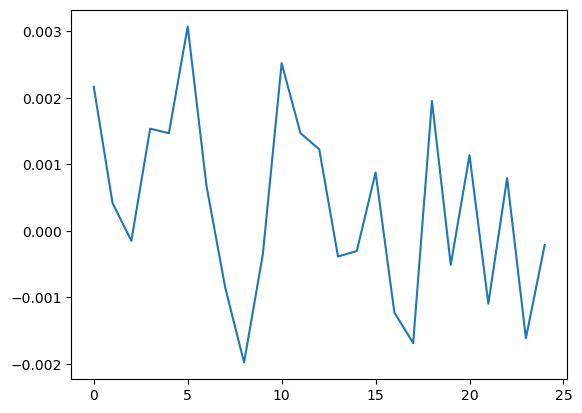

In [12]:
plt.plot(Sqs_noisy[0])